In [1]:
%load_ext lab_black
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, ReLU, LeakyReLU, GRU, Input, Concatenate
from keras.callbacks import EarlyStopping
from keras.initializers import glorot_uniform, orthogonal
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
data = pd.read_csv("../data/five_percent.csv").set_index("date")
nlp_predictions = pd.read_csv("../data/nlp_predictions.csv").set_index("date")
predictive = pd.read_csv("../data/predictive_features.csv").set_index("date")
predictive_index = predictive.index

gas_min, gas_max = data["gas_price"].min(), data["gas_price"].max()

target = "gas_price"
features = [col for col in data if col != target]

the_future = "2019-01-01"
train, test = data.loc[:the_future], data[the_future:]

In [5]:
scaler = MinMaxScaler()

train = scaler.fit_transform(train)
test = scaler.transform(test)
full_scaled = scaler.transform(data)

train = pd.DataFrame(train, columns=scaler.get_feature_names_out())
test = pd.DataFrame(test, columns=scaler.get_feature_names_out())
full_scaled = pd.DataFrame(full_scaled, columns=scaler.get_feature_names_out())

full_scaled["date"] = data.index
full_scaled = full_scaled.set_index("date")

In [6]:
predictive_scaler = MinMaxScaler()

predictive_scaler.fit(predictive.loc[:the_future])

predictive = pd.DataFrame(
    predictive_scaler.transform(predictive),
    columns=predictive_scaler.get_feature_names_out(),
)

predictive["date"] = predictive_index
predictive = predictive.set_index("date")

In [7]:
WINDOW = 52
FORECAST = 1

In [8]:
def data_windower(data, target, window=10, forecast=10):
    x_windowed = []
    y_forecasted = []
    for i in range(window, len(data) - forecast):
        x_windowed.append(data.iloc[i - window : i].values)
        y_forecasted.append(data[target].iloc[i : i + forecast].values)

    return x_windowed, y_forecasted


X_train, y_train = data_windower(train, "gas_price", window=WINDOW, forecast=FORECAST)

X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)

In [9]:
rnn = Sequential(
    [
        GRU(
            500,
            return_sequences=True,
            recurrent_initializer=orthogonal(seed=42),
            kernel_initializer=glorot_uniform(seed=42),
        ),
        GRU(
            500,
            return_sequences=True,
            recurrent_initializer=orthogonal(seed=42),
            kernel_initializer=glorot_uniform(seed=42),
        ),
        GRU(
            500,
            return_sequences=True,
            recurrent_initializer=orthogonal(seed=42),
            kernel_initializer=glorot_uniform(seed=42),
        ),
        GRU(
            500,
            return_sequences=True,
            recurrent_initializer=orthogonal(seed=42),
            kernel_initializer=glorot_uniform(seed=42),
        ),
        GRU(
            500,
            return_sequences=True,
            recurrent_initializer=orthogonal(seed=42),
            kernel_initializer=glorot_uniform(seed=42),
        ),
        GRU(
            500,
            return_sequences=True,
            recurrent_initializer=orthogonal(seed=42),
            kernel_initializer=glorot_uniform(seed=42),
        ),
        GRU(
            500,
            return_sequences=True,
            recurrent_initializer=orthogonal(seed=42),
            kernel_initializer=glorot_uniform(seed=42),
        ),
        GRU(
            500,
            return_sequences=True,
            recurrent_initializer=orthogonal(seed=42),
            kernel_initializer=glorot_uniform(seed=42),
        ),
        GRU(
            500,
            return_sequences=False,
            recurrent_initializer=orthogonal(seed=42),
            kernel_initializer=glorot_uniform(seed=42),
        ),
        Dense(256, kernel_initializer=glorot_uniform(seed=42)),
        ReLU(),
        Dense(FORECAST, kernel_initializer=glorot_uniform(seed=42)),
    ]
)

optimizer = Adam(learning_rate=1e-4, amsgrad=True)

rnn.compile(loss="mse", optimizer=optimizer)

history = rnn.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 52, 500)           798000    
                                                                 
 gru_1 (GRU)                 (None, 52, 500)           1503000   
                                                                 
 gru_2 (GRU)                 (None, 52, 500)           1503000   
                                                                 
 gru_3 (GRU)                 (None, 52, 500)           1503000   
                                                                 
 gru_4 (GRU)                 (None, 52, 500)           1503000   
                                                                 
 gru_5 (GRU)                 (None, 52, 500)           1503000   
                                                                 
 gru_6 (GRU)                 (None, 52, 500)           1

In [10]:
X_test, y_test = data_windower(test, "gas_price", window=WINDOW, forecast=FORECAST)

X_test = tf.convert_to_tensor(X_test)
y_test = tf.convert_to_tensor(y_test)

test_pred = rnn.predict(X_test)

true_plot = y_test[:, -1]
pred_plot = test_pred[:, -1]

5/5 [==============================] - 2s 17ms/step


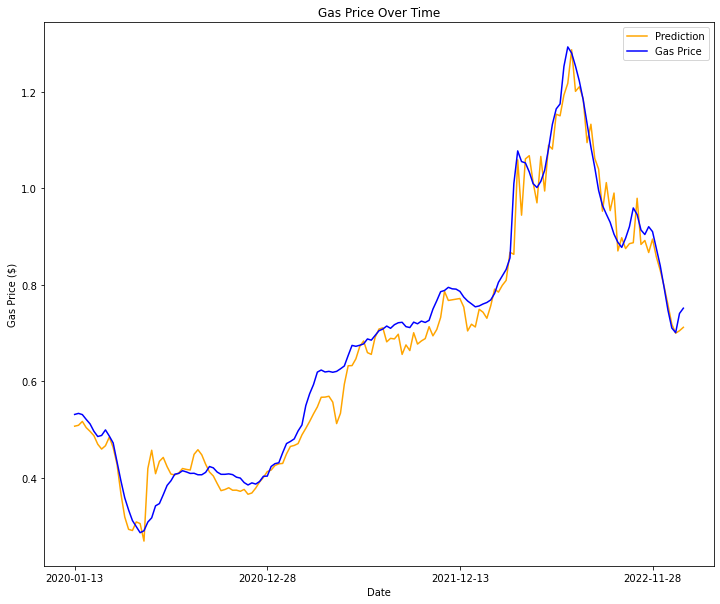

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)

future_dates = data.index[-true_plot.shape[0] :]

plotting_df = pd.DataFrame(
    {
        "pred": pred_plot,
        "true": true_plot,
        "date": future_dates,
    }
).set_index("date")

ax.plot(plotting_df["pred"], color="orange", label="Prediction")
ax.plot(plotting_df["true"], color="blue", label="Gas Price")
ticks = plotting_df.index[::50]
ax.set_xticks(ticks)
ax.set_xlabel("Date")
ax.set_ylabel("Gas Price ($)")
ax.set_title("Gas Price Over Time")
ax.legend()

In [12]:
target = "gas_price"
rnn_features = data.columns
supplemental_features = list(predictive.columns) + list(nlp_predictions.columns)

merged_data = pd.concat(
    [full_scaled, predictive, nlp_predictions], join="inner", axis=1
)

merged_data

,zeta_0,zeta_1,zeta_2,zeta_3,zeta_4,zeta_5,zeta_6,zeta_7,zeta_8,zeta_9,...,zeta_25,zeta_26,zeta_27,zeta_28,gas_price,short_linear_projection,long_linear_projection,ols,arima,nlp_label
date,,,,,,,,,,,,,,,,,,,,,
2005-02-28,0.470031,0.254887,0.372764,0.590353,0.369454,0.533583,0.303406,0.498744,0.522320,0.464859,...,0.472076,0.099040,0.457345,0.338077,0.310634,0.313309,0.308254,0.299763,0.337209,0.000000
2005-03-07,0.458451,0.164667,0.235700,0.622465,0.286955,0.574743,0.252201,0.549003,0.522164,0.485924,...,0.345130,0.149071,0.623456,0.469286,0.317164,0.324091,0.316295,0.305159,0.385395,0.000000
2005-04-11,0.467691,0.141435,0.256562,0.556270,0.318399,0.402343,0.528532,0.558085,0.515809,0.420104,...,0.480783,0.114450,0.327785,0.448578,0.407027,0.426371,0.412412,0.382198,0.410898,0.000000
2005-04-25,0.460905,0.231245,0.271062,0.457660,0.382413,0.448892,0.607299,0.562214,0.493958,0.366812,...,0.609113,0.293086,0.234603,0.409581,0.413868,0.400801,0.418098,0.416601,0.395873,1.000000
2005-05-09,0.469537,0.268725,0.339197,0.410571,0.378610,0.313665,0.737834,0.578678,0.507836,0.409543,...,0.590176,0.427177,0.348320,0.419429,0.412935,0.411892,0.417212,0.423906,0.411468,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,0.110582,0.356244,-0.085174,-0.217410,0.675838,0.465971,0.229828,0.434257,0.573159,0.600270,...,0.376000,0.223081,0.367571,0.464694,0.710510,0.670672,0.675268,0.955154,0.583517,-0.133333
2023-01-02,0.110659,0.394549,-0.113797,-0.165376,0.650346,0.455366,0.245122,0.417374,0.568288,0.611532,...,0.582881,0.100679,0.169093,0.438685,0.700871,0.688232,0.666188,0.943037,0.588457,-0.056738
2023-01-09,0.109476,0.404027,-0.142346,-0.116197,0.611711,0.445960,0.245803,0.414374,0.580693,0.628223,...,0.376708,0.267337,0.376106,0.459023,0.740672,0.776648,0.712382,0.924717,0.595641,-0.035971


In [13]:
X_rnn, y = data_windower(
    merged_data[rnn_features], target, window=WINDOW, forecast=FORECAST
)

index_of_the_future = len(merged_data.loc[:the_future]) - WINDOW

X_rnn_train = tf.convert_to_tensor(X_rnn[:index_of_the_future])
X_rnn_test = tf.convert_to_tensor(X_rnn[index_of_the_future:])

X_sup_train = tf.convert_to_tensor(
    merged_data[supplemental_features].iloc[WINDOW:].loc[:the_future]
)
X_sup_test = tf.convert_to_tensor(
    merged_data[supplemental_features].loc[the_future:].iloc[:-1]
)

y_train = tf.convert_to_tensor(y[:index_of_the_future])
y_test = tf.convert_to_tensor(y[index_of_the_future:])

In [14]:
rnn_input = Input(
    shape=(WINDOW, len(rnn_features)),
    name="rnn_input",
)
supplemental_input = Input(
    shape=(len(supplemental_features),), name="supplemental_input"
)

rnn_pred = rnn(rnn_input)

merged = Concatenate()([rnn_pred, supplemental_input])

dnn0 = Dense(256, activation="relu")(merged)
dnn1 = Dense(128, activation="relu")(dnn0)
dnn2 = Dense(64, activation="relu")(dnn1)
output = Dense(1)(dnn2)

model = keras.Model(inputs=[rnn_input, supplemental_input], outputs=[output])

In [15]:
model.compile(loss="mse", optimizer="adam")
model.fit(
    {"rnn_input": X_rnn_train, "supplemental_input": X_sup_train},
    y_train,
    epochs=100,
    batch_size=32,
    verbose=0,
)

In [16]:
def inverse_transform(y, gas_min, gas_max):
    return y * (gas_max - gas_min) + gas_min

In [17]:
y_pred = model.predict({"rnn_input": X_rnn_test, "supplemental_input": X_sup_test})

y_pred = inverse_transform(y_pred, gas_min, gas_max)
y_test = inverse_transform(y_test, gas_min, gas_max)

7/7 [==============================] - 2s 18ms/step


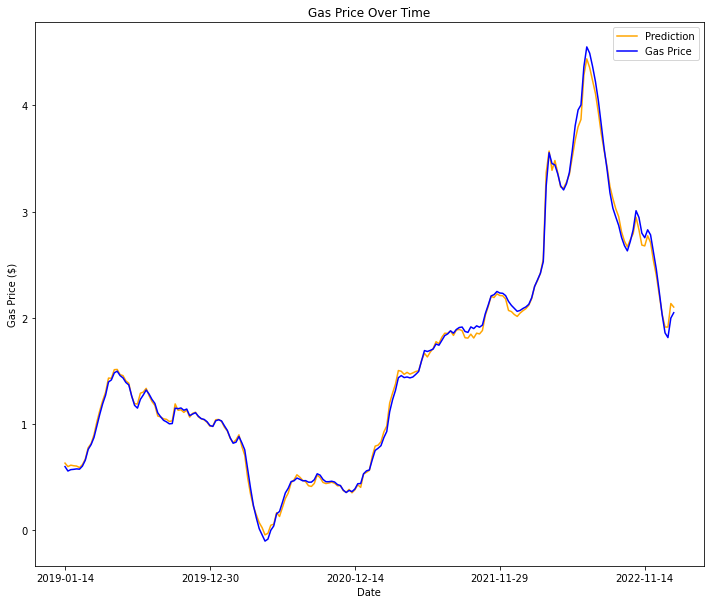

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)

future_dates = merged_data.index[-y_test.shape[0] :]

plotting_df = pd.DataFrame(
    {
        "pred": np.reshape(y_pred, (-1,)),
        "true": np.reshape(y_test, (-1,)),
        "date": future_dates,
    }
).set_index("date")

ax.plot(plotting_df["pred"], color="orange", label="Prediction")
ax.plot(plotting_df["true"], color="blue", label="Gas Price")
ticks = plotting_df.index[::50]
ax.set_xticks(ticks)
ax.set_xlabel("Date")
ax.set_ylabel("Gas Price ($)")
ax.set_title("Gas Price Over Time")
ax.legend()

In [19]:
mean_squared_error(y_pred, y_test, squared=False)

0.04762098334760659

In [20]:
mean_absolute_error(y_pred, y_test)

0.03526012767170882